<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/full_twitter_sentiment_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git
!pip install transformers
!pip install scikit-optimize
!pip install optuna

In [0]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
from fastai.callbacks import *

import torch
import torch.optim as optim

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
show_install()




```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61.dev0
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run th

In [0]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)



fastai version : 1.0.61.dev0
transformers version : 2.5.1


# Exploratory Data Analysis

In [0]:
df = pd.read_csv('testset1.csv')

In [0]:
print(len(df))

df.head(5)

5585


,id,name,date,text,location,sentiment
0,1.130000e+18,Evolutionomics,Sun May 19 23:57:10 +0000 2019,By combining short positions on #Gold $GOLD $G...,NaN,bearish
1,1.130000e+18,macrohedged,Sun May 19 23:55:02 +0000 2019,Here are the #Volatility levels for the majors...,England,unrelated
2,1.130000e+18,Evolutionomics,Sun May 19 23:54:06 +0000 2019,We have little insight into what will happen t...,NaN,neutral
3,1.130000e+18,Evolutionomics,Sun May 19 23:50:59 +0000 2019,"This brings us to #Gold miners. As a group, $G...",NaN,neutral
4,1.130000e+18,macrohedged,Sun May 19 23:50:04 +0000 2019,"Good morning Asia, here are the benchmark futu...",England,unrelated


['bearish' 'unrelated' 'neutral' 'bullish']


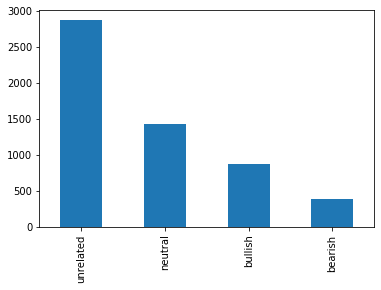

In [0]:
df['sentiment'].value_counts().plot(kind='bar')

print(df['sentiment'].unique())

Unrelated and neutral sentiments dominate the data currently (although this might not be the case in the future with the full dataset). It might be better to use a stratified sampling technique for classification

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(df['text'], df['sentiment'])

print(sss)



StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [0]:
train_idx, val_idx = next(sss.split(df['text'], df['sentiment']))

print(len(train_idx), len(val_idx))

4468 1117


Verifying that the stratified split preseves the distribution of the labels

In [0]:
df_train = df.iloc[train_idx, :]
df_val = df.iloc[val_idx, :]

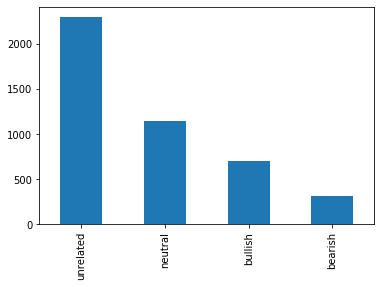

In [0]:
df_train['sentiment'].value_counts().plot(kind='bar')

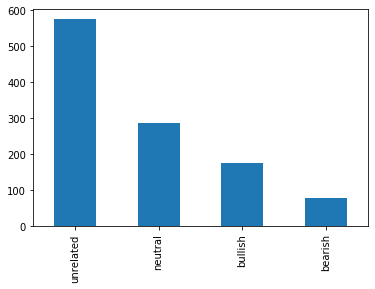

In [0]:
df_val['sentiment'].value_counts().plot(kind='bar')

Looks like the distribution of the labels in train and val are the same, so we can start modelling now

# Setting up data for transformers

In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}


In [0]:
# Parameters
# seed = 42
use_fp16 = False
model_type = 'roberta'
pretrained_model_name = 'roberta-base' 

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

## Setting up tokenizer + numericalizer


In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [0]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
tokenizer_class.pretrained_vocab_files_map

{'merges_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-merges.txt',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt',
  'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-merges.txt',
  'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt'},
 'vocab_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-vocab.json',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'robert

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer

    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up Data


In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [0]:
bs = 32

data_clas = (TextList.from_df(df, cols='text', processor=transformer_processor)
             .split_by_idxs(train_idx, val_idx)
             .label_from_df(cols= 'sentiment')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))



In [0]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> Ġ ðĿ Ļ Ī ðĿ Ļ Ģ ðĿ Ļ Ī ðĿ Ļ Ĭ ðĿ Ļ į ðĿ Ļ Ħ ðĿ ĺ ¼ ðĿ Ļ ĩ Ġ ðĿ ĺ ¿ ðĿ ĺ ¼ ðĿ Ļ Ķ Ġ ðĿ ĺ ¿ ðĿ Ļ Ħ ðĿ Ļ İ ðĿ ĺ ¾ ðĿ Ļ Ĭ ðĿ Ļ Ĳ ðĿ Ļ ī ðĿ Ļ ı Ġ ðĿ Ļ Ĭ ðĿ Ļ ģ ðĿ Ļ,unrelated
"<s> ĠðŁ Ķ » - 0 . 77 % â ļ ĸ ï¸ı : ðŁ ķ · & amp ; ðŁ Ĺ ĥ Ġ# ETF s Ċ # Morning Ġ# Market Ġ# G ap Ċ Thu , ĠMay Ġ23 Ċ Ċ ðŁ į ı Ċ 0 . 48 % ðŁ ı ħ Ġ$ GL D Ċ 0 . 10 % ðŁ Ķ Į Ġ$ XL U Ċ Ċ ðŁ Ķ",neutral
<s> ĠðŁ Ķ » - 1 . 4 % â ļ ĸ ï¸ı ðŁ ķ · & amp ; ðŁ Ĺ ĥ Ġ# ETF s Ċ # Week ly Ġ# Market Ġ# Change Ċ Week Ġ22 Ċ Ċ ðŁ į ı # Up Ċ 2 . 07 % ðŁ ı ħ Ġ$ GL D Ċ 0 . 27 % ðŁ ı ¡ Ġ$ XL RE Ċ Ċ ðŁ Ķ »,neutral
"<s> ĠðŁ į ı 0 . 5 % â ļ ĸ ï¸ı : ðŁ ķ · & amp ; ðŁ Ĺ ĥ Ġ# ETF s Ċ # Morning Ġ# Market Ġ# G ap Ċ Tue , ĠMay Ġ21 Ċ Ċ 1 . 05 % ðŁ Ĵ » Ġ$ XL K Ċ 0 . 86 % âĻ £ ï¸ı Ġ$ Q Q Q Ċ 0 . 86 % ðŁ ı Ń",unrelated
"<s> ĠChina Ġis Ġalready Ġdumping Ġits ĠU . S . D ĠAnd ĠLoading Ġup Ġon Ġ$ Gold . Ġ# China Ġwinding Ġdown ĠU . ĠS Ġ# Tre as uries , Ġloading Ġup ĠGold . ĠRead Ġmore Ġhttps :// t . co / ro Hy qt K rd 5 Ġ ĠðŁ Ĵ Ľ ðŁ Ĵ ľ ðŁ Ĵ Ľ ðŁ Ĵ ľ ðŁ Ĵ Ľ ðŁ Ĵ ľ ðŁ Ĵ ľ",bullish


In [0]:
# checking batch and numericalizer

print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_clas.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)



[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([32, 251])
tensor([[    0,  1437, 40756,  ...,   288,   100,     2],
        [    0,  8103,  8384,  ...,     1,     1,     1],
        [    0,  8103, 10674,  ...,     1,     1,     1],
        ...,
        [    0,   392, 29974,  ...,     1,     1,     1],
        [    0,   392, 29974,  ...,     1,     1,     1],
        [    0,   392, 29974,  ...,     1,     1,     1]])


# RoBERTa

In [0]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [0]:
n_labels = 4

config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = n_labels
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 4,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_size": 1,
  "us

In [0]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Creating learner

In [0]:
from transformers import AdamW


In [0]:
try: 
    learn.destroy()
except:
    'no learner created'

learn = Learner(data_clas,
               custom_transformer_model,
               opt_func = lambda input: AdamW(input,correct_bias=False),
               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
               metrics = [accuracy])

# learn = Learner(data_clas,
#                custom_transformer_model,
#             #    opt_func = lambda input: AdamW(input,correct_bias=False),
#                opt_func = optar,
#                loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
#                metrics = [accuracy])

this Learner object self-destroyed - it still exists, but no longer usable


### Creating layer splitting for gradual unfreezing and discriminative learning rates

use   "num_hidden_layers" in config + 2 (1 for embedding and 1 for head)

In [0]:
# For roberta-base
list_layers = [learn.model.transformer.roberta.embeddings,
              learn.model.transformer.roberta.encoder.layer[0],
              learn.model.transformer.roberta.encoder.layer[1],
              learn.model.transformer.roberta.encoder.layer[2],
              learn.model.transformer.roberta.encoder.layer[3],
              learn.model.transformer.roberta.encoder.layer[4],
              learn.model.transformer.roberta.encoder.layer[5],
              learn.model.transformer.roberta.encoder.layer[6],
              learn.model.transformer.roberta.encoder.layer[7],
              learn.model.transformer.roberta.encoder.layer[8],
              learn.model.transformer.roberta.encoder.layer[9],
              learn.model.transformer.roberta.encoder.layer[10],
              learn.model.transformer.roberta.encoder.layer[11],
              learn.model.transformer.roberta.pooler]

In [0]:
# check groups
learn.split(list_layers)
num_groups = len(learn.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learn.layer_groups)



Learner split in 14 groups


Optional: Freeze the model to train the head

In [0]:
learn.freeze();

# learn.unfreeze();
learn.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [251, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [251, 768]           394,752    False     
______________________________________________________________________
Embedding            [251, 768]           768        False     
______________________________________________________________________
LayerNorm            [251, 768]           1,536      False     
______________________________________________________________________
Dropout              [251, 768]           0          False     
______________________________________________________________________
Linear               [251, 768]           590,592    False     
______________________________________________________________________
Linear               [251, 768]           590,592    False     
_______________________________________

## Save model weights

In [0]:
learn.save('initial')

In [0]:
list(learn.model.parameters())[1]

Parameter containing:
tensor([[-0.0115,  0.0204,  0.0197,  ...,  0.0050, -0.0274, -0.0439],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0346, -0.0169, -0.0895,  ..., -0.0542,  0.0291,  0.0173],
        ...,
        [ 0.1191, -0.0587, -0.0396,  ..., -0.0179,  0.1249,  0.0205],
        [ 0.0833, -0.0272, -0.0368,  ..., -0.0429,  0.1288, -0.0052],
        [ 0.0850,  0.2573, -0.1257,  ..., -0.0952,  0.1443, -0.0131]],
       device='cuda:0', requires_grad=True)

# Training Learner

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 3.02E-04


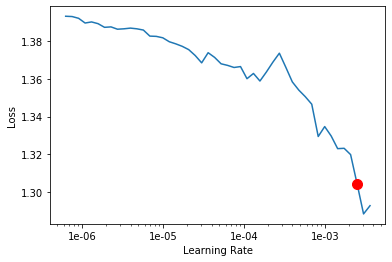

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

epoch,train_loss,valid_loss,accuracy,time
0,0.802109,0.736474,0.784244,00:11
1,0.808135,0.724193,0.790510,00:11
2,0.784474,0.711015,0.809311,00:10
3,0.782247,0.720347,0.813787,00:11
4,0.744414,0.707039,0.828111,00:10
5,0.743123,0.693896,0.810206,00:10
6,0.767134,0.683344,0.830797,00:11
7,0.741597,0.681573,0.825425,00:11
8,0.745926,0.681753,0.829902,00:11
9,0.740143,0.677007,0.829902,00:12


Better model found at epoch 0 with accuracy value: 0.7842435240745544.
Better model found at epoch 1 with accuracy value: 0.7905102968215942.
Better model found at epoch 2 with accuracy value: 0.8093106746673584.
Better model found at epoch 3 with accuracy value: 0.8137869238853455.
Better model found at epoch 4 with accuracy value: 0.8281109929084778.
Better model found at epoch 6 with accuracy value: 0.8307967782020569.


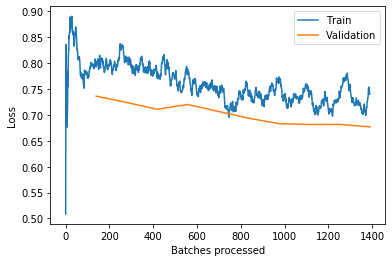

In [0]:
learn.to_fp16();

lr = 1e-3

"""Training without adjusting the momentum"""
# learn.fit_one_cycle(3, 
#                     lr, 
#                     pct_start = 0.3,
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])

"""Training discriminative learning rates"""
# learn.fit_one_cycle(3, 
#                     slice(lr/10, lr), 
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])


"""
Clipping momentum
"""

learn.fit_one_cycle(10, 
                    lr, 
                    moms=(0.8,0.7),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage1')])

learn.recorder.plot_losses()

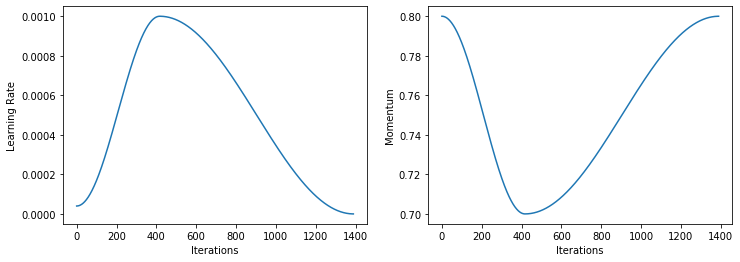

In [0]:
learn.recorder.plot_lr(show_moms=True)

### Unfreezing entire model and use discriminative learning rates

In [0]:
try: 
    learn.load('classifier_stage1')
except:
    print('no learner created')
learn.unfreeze();

### Training for another cycle

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-07


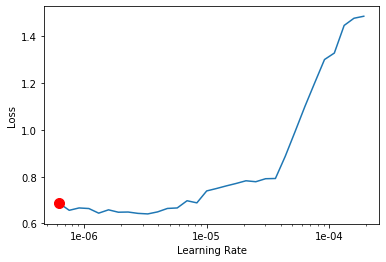

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

epoch,train_loss,valid_loss,accuracy,time
0,0.703235,0.673311,0.833483,00:31
1,0.705315,0.662848,0.848702,00:32
2,0.710926,0.653754,0.847807,00:35
3,0.690152,0.640423,0.864816,00:33
4,0.673446,0.635589,0.862131,00:35
5,0.670222,0.641860,0.862131,00:34
6,0.639145,0.629810,0.863921,00:34
7,0.654244,0.629112,0.869293,00:35
8,0.615662,0.625773,0.864816,00:35
9,0.599517,0.627346,0.866607,00:34


Better model found at epoch 0 with accuracy value: 0.833482563495636.
Better model found at epoch 1 with accuracy value: 0.8487018942832947.
Better model found at epoch 3 with accuracy value: 0.8648164868354797.
Better model found at epoch 7 with accuracy value: 0.8692927360534668.


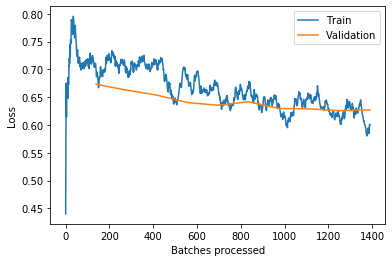

In [0]:
lr = 3e-6
"""Training without adjusting the momentum"""
# learn.fit_one_cycle(10, 
#                     slice(lr/100,lr/10),
#                     pct_start = 0.3, 
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage2')])

# """Training discriminative learning rates"""
# learn.fit_one_cycle(5, 
#                     slice(lr/10, lr), 
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage2')])
"""
Clipping momentum
"""


learn.fit_one_cycle(10, 
                    slice(lr/9,lr), 
                    moms=(0.8,0.7),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage2')])




learn.recorder.plot_losses()

**Results**

Approximiately 87% accuracy when fine-tuned


### Getting validation accuracy

1st way: using learn.get_preds() and accuracy

In [0]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss = True)
print(accuracy(preds, y))

2nd way: using learn.validate()

In [0]:
val_accuracy = learn.validate(learn.data.valid_dl)[1].numpy()


In [0]:
print(val_accuracy)
type(val_accuracy)

# Hyperparam Tuning with Optuna (TPE + Hyperband Pruner)

In [0]:
import optuna
from optuna.integration import FastAIPruningCallback

In [0]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
    pct_start = trial.suggest_uniform('pct_start', 0.05, 0.5)
    b1 = trial.suggest_uniform('b1', 0.7, 0.9)
    b2 = trial.suggest_uniform('b2', 0.6, 0.999)
    eps = trial.suggest_categorical('eps', [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    wd = trial.suggest_loguniform('wd', 1e-8, 0.2)

    # destroy old learner
    try: 
        learn.destroy()
    except:
        print('no learner created')

    learn = Learner(data_clas,
        custom_transformer_model,
        opt_func = lambda input: AdamW(input,correct_bias=False, eps=eps),
        loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
        metrics = [accuracy],
        wd = wd,
        callback_fns=[partial(FastAIPruningCallback, trial=trial, monitor='valid_loss')])
    
    # For roberta-base
    list_layers = [learn.model.transformer.roberta.embeddings,
                learn.model.transformer.roberta.encoder.layer[0],
                learn.model.transformer.roberta.encoder.layer[1],
                learn.model.transformer.roberta.encoder.layer[2],
                learn.model.transformer.roberta.encoder.layer[3],
                learn.model.transformer.roberta.encoder.layer[4],
                learn.model.transformer.roberta.encoder.layer[5],
                learn.model.transformer.roberta.encoder.layer[6],
                learn.model.transformer.roberta.encoder.layer[7],
                learn.model.transformer.roberta.encoder.layer[8],
                learn.model.transformer.roberta.encoder.layer[9],
                learn.model.transformer.roberta.encoder.layer[10],
                learn.model.transformer.roberta.encoder.layer[11],
                learn.model.transformer.roberta.pooler]

    learn.split(list_layers)
    learn.load('initial')
    learn.unfreeze()
    learn.to_fp16()
    learn.fit_one_cycle(3, 
                slice(lr/9, lr),
                # lr,
                pct_start = pct_start,
                moms = (b1, b2))

    return learn.validate()[-1].item() # returns accuracy


Run study

In [0]:
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)

study.optimize(objective, n_trials=250, timeout=120*60)
print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Train model with tuned hyperparameters

In [0]:
try: 
    learn.destroy()
except:
    'no learner created'

learn = Learner(data_clas,
               custom_transformer_model,
               opt_func = lambda input: AdamW(input,correct_bias=False, eps = 1e-4),
               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
               metrics = [accuracy])

this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
learn.to_fp16()

lr = 2.34e-5
pct_start = 0.364
b1 = 0.83
b2 = 0.91
learn.fit_one_cycle(5, 
            lr,
            pct_start = pct_start,
            moms = (b1, b2),
            callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                name='classifier_optuna')])

epoch,train_loss,valid_loss,accuracy,time
0,0.662620,0.654050,0.864816,00:33
1,0.670050,0.622398,0.876455,00:34
2,0.573646,0.574386,0.897941,00:30
3,0.486312,0.580335,0.906893,00:31
4,0.449413,0.580074,0.904208,00:31


Better model found at epoch 0 with accuracy value: 0.8648164868354797.
Better model found at epoch 1 with accuracy value: 0.876454770565033.
Better model found at epoch 2 with accuracy value: 0.8979409337043762.
Better model found at epoch 3 with accuracy value: 0.9068934917449951.


We can get around 91% accuracy in 1/4 the epochs with properly tuned hyperparameters

# Inference

We can use `learn.export()` to export the learner as a `.pkl` file, which can then be called as a function using `learn = load_learner($data_path$)` in a deployment setting